## Fitness Tracker Analysis - Part 3

**Continued from Part 2 here:**

`/notebooks/nk-fitness-tracker-p2-outlier-removal.ipynb`

Github link: https://github.com/nkeblawi/nk-fitness-tracker/blob/main/notebooks/nk-fitness-tracker-p2-outlier-removal.ipynb

### 3.1 - Feature Engineering

The next step is to prepare each feature to get the best results possible from modeling. There are multiple steps in the feature engineering process, including imputation, noise reduction (smoothing), principal component analysis (PCA), etc. 

In [43]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import src.visualization.visualize as vis

In [44]:
# Set up the plotting styles
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [45]:
# Load the data with outliers removed
df = pd.read_pickle("data/interim/02_data_outliers_removed_chauvenets.pkl")

# Assign the predictor columns (sensor data)
predictor_columns = df.columns[:6]

### 3.2 - Imputation

I've decided to impute missing values by interpolating the gap between known values. This is simply done by calling the `interpolate()` function. 

In [46]:
for col in predictor_columns:
    df[col] = df[col].interpolate()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 774.2+ KB


### 3.3 - Calculate the Set Duration

Before we go further with smoothing the data, we want to know how long each set usually lasts. Then we can apply a lowpass filter to smooth out high-frequency noise without oversmoothing repetitions with a set.

In [47]:
for s in df["set"].unique():
    set_start = df[df["set"] == s].index[0]
    set_stop = df[df["set"] == s].index[-1]

    set_duration = set_stop - set_start
    df.loc[(df["set"] == s), "set_duration"] = set_duration.seconds

duration_df = df.groupby(["category"])["set_duration"].mean()

print(f"Average duration of a rep in a heavy set: {duration_df.iloc[0] / 5}")
print(f"Average duration of a rep in a medium set: {duration_df.iloc[1] / 10}")

Average duration of a rep in a heavy set: 2.9487001733102254
Average duration of a rep in a medium set: 2.4942528735632186


### 3.4 - Butterworth Low-pass Filter

Now that we know how long each rep is (2.5-3 seconds), we can apply a butterworth low-pass filter to smooth out the noisy data to make it more coherent for the models to train only on the big movements.

A visual example of applying a lowpass filter can be seen here:

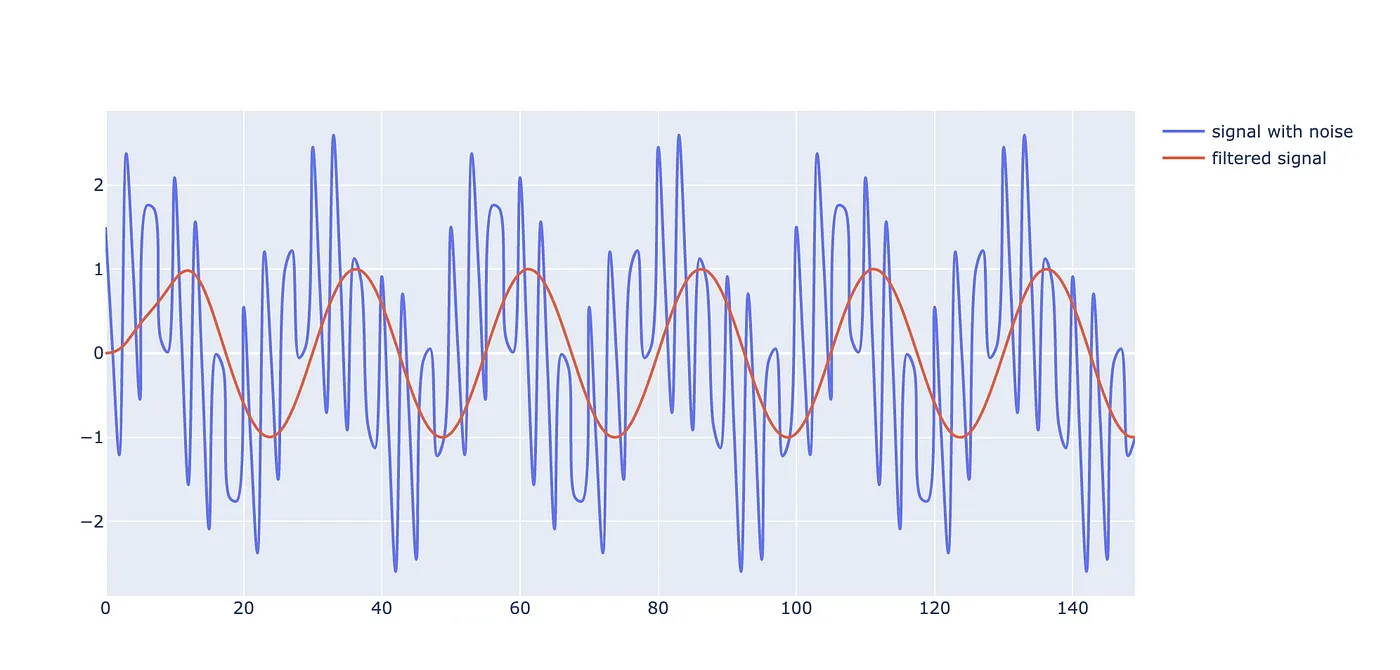

Source: https://medium.com/analytics-vidhya/how-to-filter-noise-with-a-low-pass-filter-python-885223e5e9b7

More information about this method can be found here:

*Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self. On the art of learning from sensory data.*

In [48]:
# Import the library containing the source code for thelowpass filter
from src.features.DataTransformation import LowPassFilter

# Create an instance of the LowPassFilter class
LowPass = LowPassFilter()

# First make a copy of the dataframe, so we don't break the original
df_lowpass = df.copy()

Before we apply the lowpass filter, set the sampling frequency to 5 Hz and assign a cutoff value between 1 and 2:

In [49]:
fs = 1000 / 200  # sampling frequency (200ms)
cutoff = 1.3  # test this value and adjust as needed

Now apply the lowpass filter to the `acc_y` column:

In [50]:
# Apply the low pass filter to the acc_y column
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

Compare the new column vs the original to check the effect of the low pass filter in the following visualization (for deadlifts):

dead


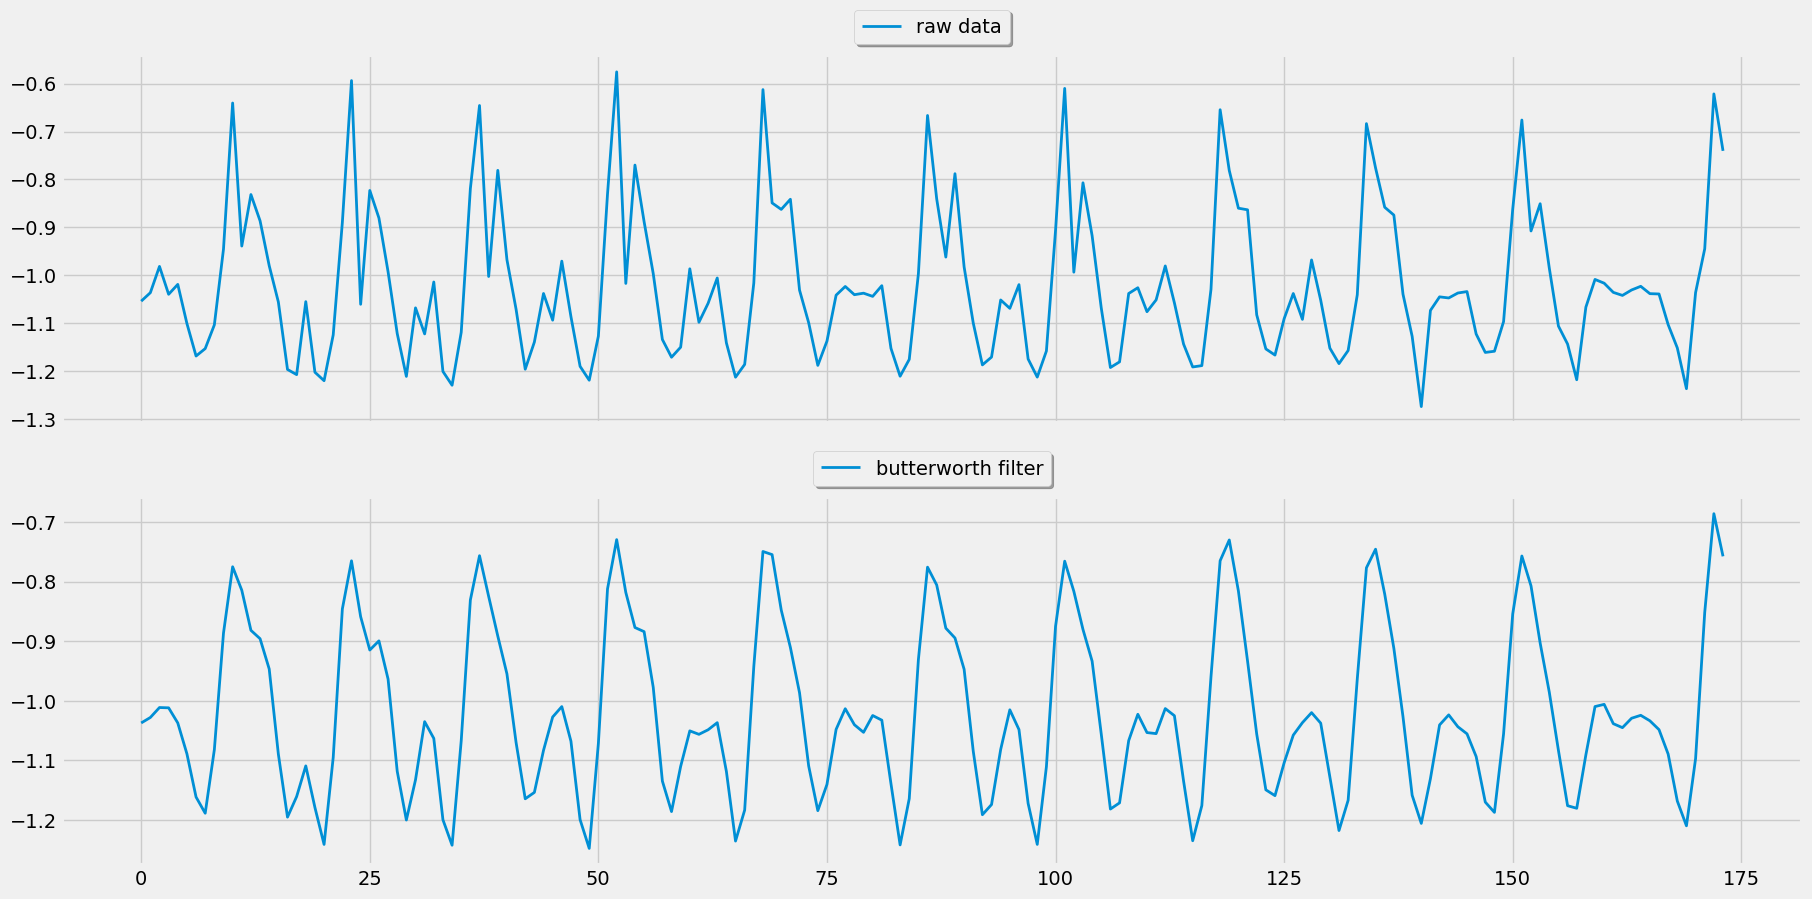

In [51]:
subset = df_lowpass[df_lowpass["set"] == 45]
print(subset["label"][0])

col_name = "acc_y" # change this to the column you want to plot
vis.test_lowpass_filter_plot(subset, col_name)

Once we are satisifed with the cutoff value, apply the lowpass filter to all predictor columns:

In [52]:
# Once the cutoff value is selected, apply the filter to all columns
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)

    # Overwrite the original column with the low pass filtered column
    df_lowpass[col] = df_lowpass[col + "_lowpass"]
    del df_lowpass[col + "_lowpass"]

### 3.5 - Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique where we use the elbow technique can be used to determine the optimal number of components to use when conducting PCA. This helps determine the number of components that explain the most variance for the model to train on.

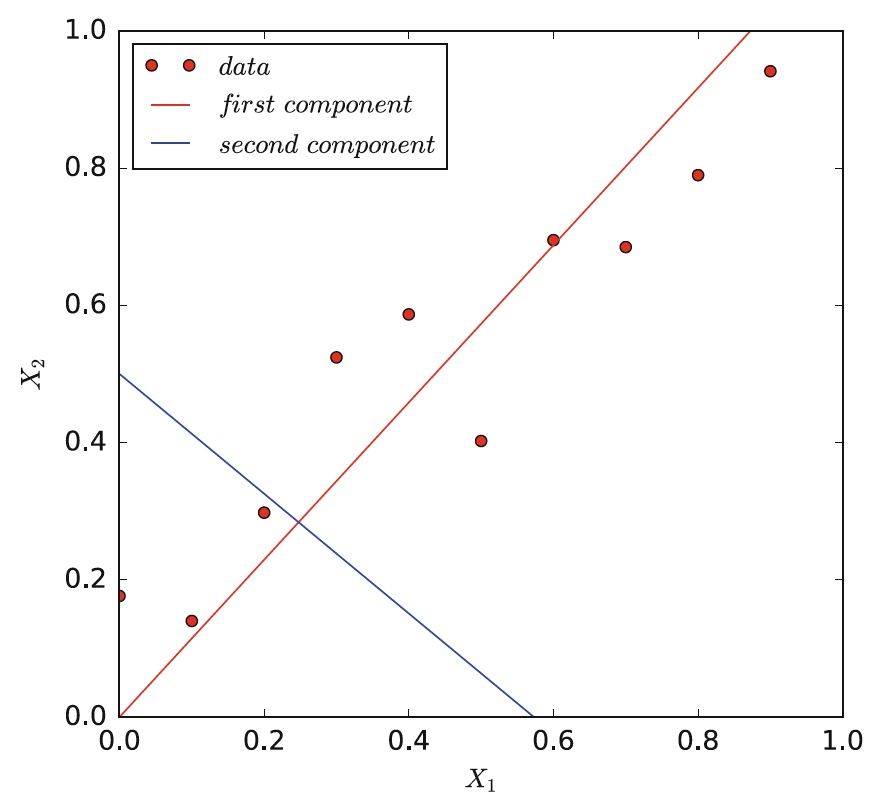

My favorite YouTube video that explains PCA most clearly is Josh Starmer's StatQuest PCA explainer:

https://www.youtube.com/watch?v=FgakZw6K1QQ

In [53]:
# Import the library containing the source code for PCA
from src.features.DataTransformation import PrincipalComponentAnalysis

Apply PCA on the predictor columns:


In [54]:
# Make a copy of the dataframe from the previous cell with lowpass applied
df_pca = df_lowpass.copy()

# Create an instance of the PCA class
PCA = PrincipalComponentAnalysis()

# Determine the explained variance for each principal component
pc_values = PCA.determine_pc_explained_variance(df_pca, predictor_columns)

Create an elbow plot of explained variances by number of components:

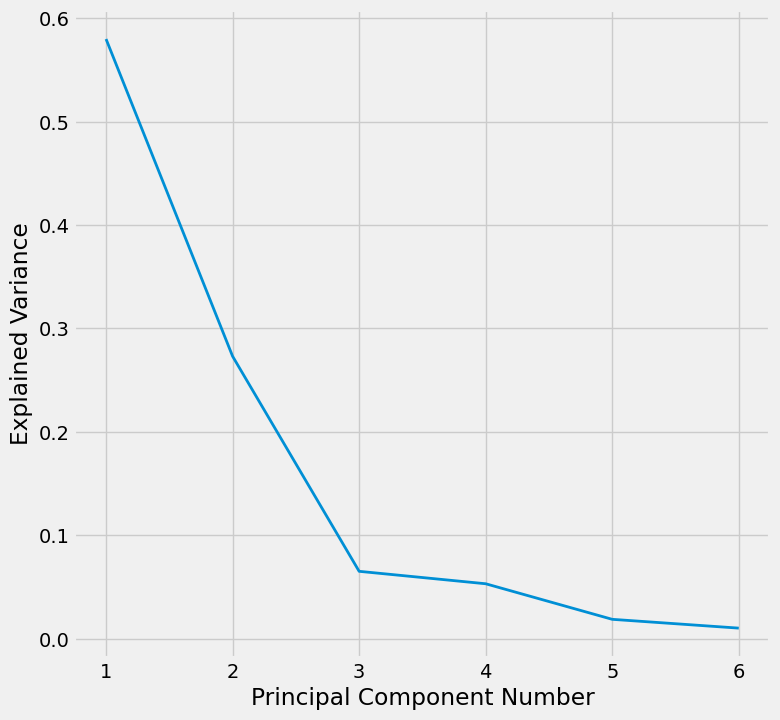

In [55]:
import src.visualization.visualize as vis

vis.plot_pc_explained_variance(pc_values, predictor_columns)

Most of the variances can be explained by the first 2 or 3 components. I decided to use 3 components and not 4, since it's easier to visualize. PCA is applied to the dataset with 3 components.

<Axes: xlabel='epoch (ms)'>

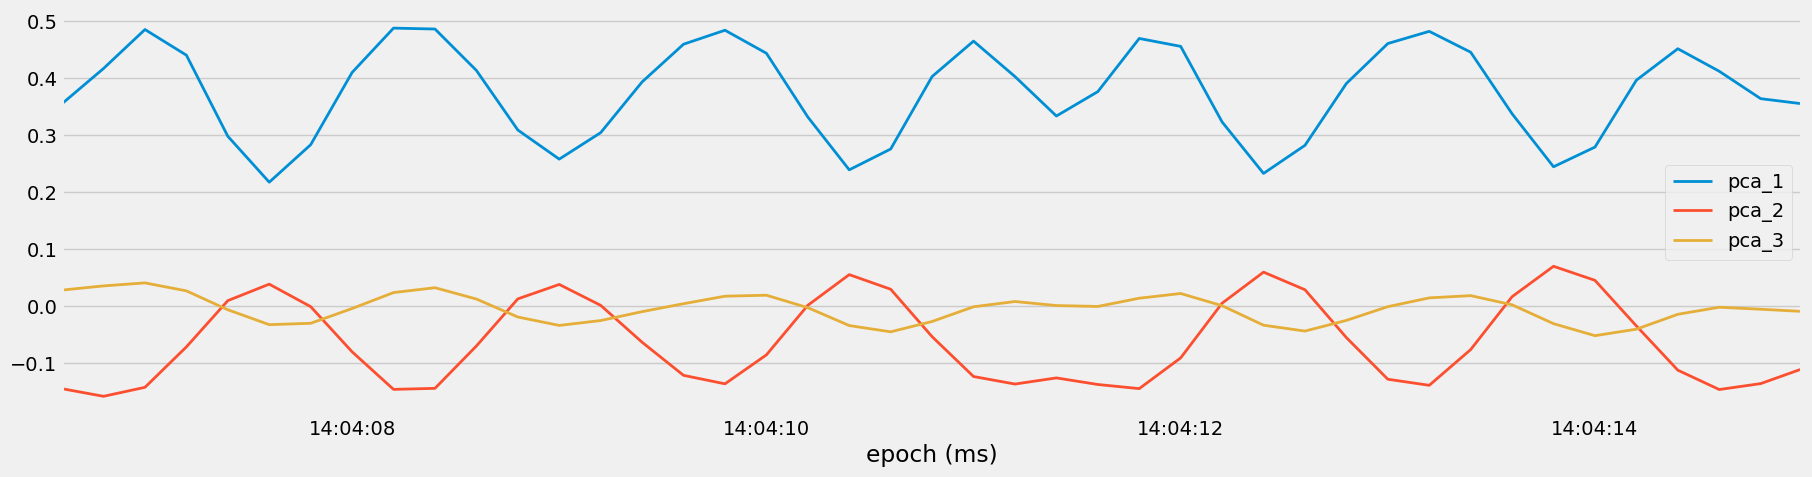

In [56]:
# Set number of components
n_components = 3

# Add only the first 3 principal components to the dataframe
df_pca = PCA.apply_pca(df_pca, predictor_columns, n_components)

# Plot a subset of the data to see the effects of PCA
subset = df_pca[df_pca["set"] == 35]
subset[["pca_1", "pca_2", "pca_3"]].plot()

### 3.6 - Sum of Squares

Since both accelerometer and gyroscope data have three axes of motion (x, y, z), we can calculate a scalar by taking the square root of the sum of squares of x, y, and z. 

The benefit of using a scalar variable is that it is independent of device orientation and can thus handle dynamic re-orientations. 

Sum of squares will be added for both accelerometer and gyroscope:

array([<Axes: xlabel='epoch (ms)'>, <Axes: xlabel='epoch (ms)'>],
      dtype=object)

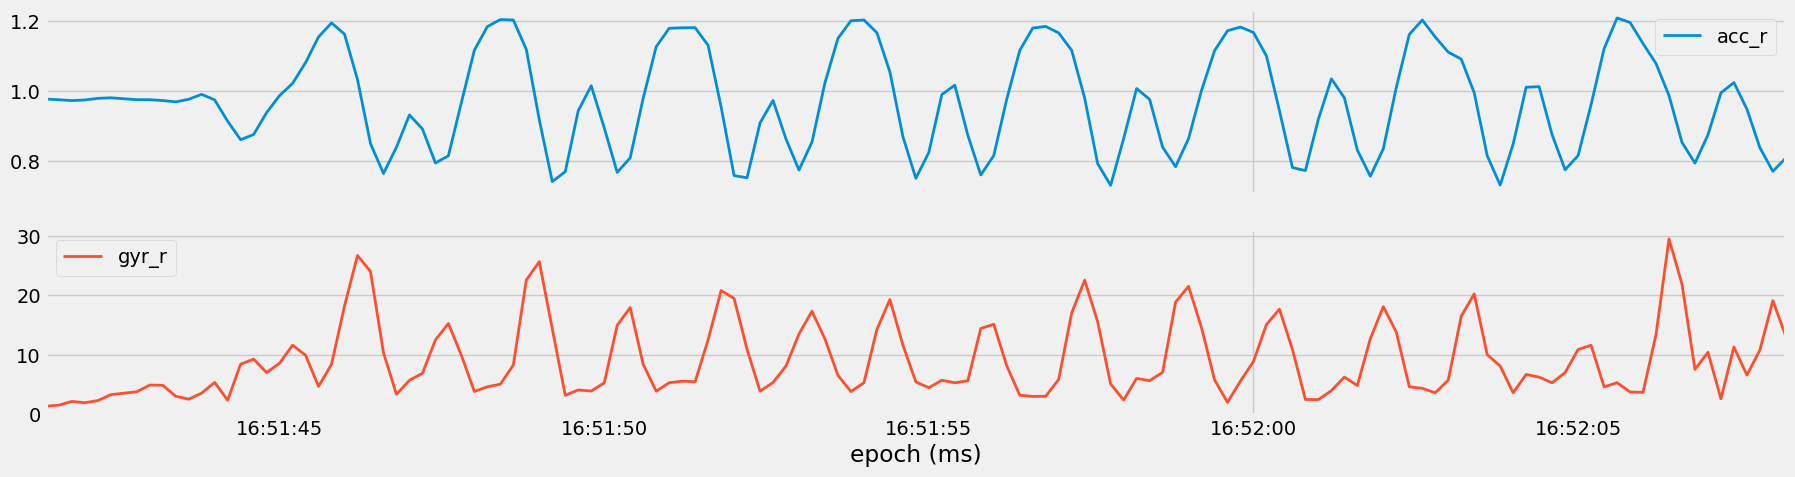

In [57]:
# Make a copy of the dataframe from the previous cell with PCA added
df_squared = df_pca.copy()

# Calculate the sum of squares of acc and gyr
acc_r = df_squared["acc_x"] ** 2 + df_squared["acc_y"] ** 2 + df_squared["acc_z"] ** 2
gyr_r = df_squared["gyr_x"] ** 2 + df_squared["gyr_y"] ** 2 + df_squared["gyr_z"] ** 2

# Add the sum of squares to the dataframe
df_squared["acc_r"] = np.sqrt(acc_r)
df_squared["gyr_r"] = np.sqrt(gyr_r)

# Inspect the sum of squares by plotting these for a set
subset = df_squared[df_squared["set"] == 14]
subset[["acc_r", "gyr_r"]].plot(subplots=True)

### 3.7 - Temporal Abstraction

Since the dataset in its current state contains five observations for each second, it may be useful to create a rolling average of the original six motion features plus the two scalars.

In [58]:
# Load the necessary library
from src.features.TemporalAbstraction import NumericalAbstraction

# Make a copy of the dataframe from the previous cell where sum of squares were added
df_temporal = df_squared.copy()

# Create an instance of the NumericalAbstraction class
NumAbs = NumericalAbstraction()

In [59]:
# Initialize an empty list of predictor columns
pred_col_list = []

# Add the original six predictor columns to the list
pred_col_list = list(predictor_columns)

# Plus the two scalars
pred_col_list.append("acc_r")
pred_col_list.append("gyr_r")

This may bear further testing, but the rolling average window size is set to one second.

In [60]:
window_size = int(1000 / 200)  # One second

Not only do we get the rolling average, but also the standard deviation of the data within the 1-second window:

In [61]:
# Apply the temporal abstraction set by set
df_temporal_list = []
for s in df_temporal["set"].unique():
    subset = df_temporal[df_temporal["set"] == s].copy()
    for col in pred_col_list:
        subset = NumAbs.abstract_numerical(subset, [col], window_size, "mean")
        subset = NumAbs.abstract_numerical(subset, [col], window_size, "std")
    df_temporal_list.append(subset)

Append the temporal features to the panda dataframe (some missing data is to be expected as would naturally happen when taking rolling averages):

In [62]:
df_temporal = pd.concat(df_temporal_list)
df_temporal.info()  # shows rolling averages have only 8,645 non-null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   acc_x                 9009 non-null   float64
 1   acc_y                 9009 non-null   float64
 2   acc_z                 9009 non-null   float64
 3   gyr_x                 9009 non-null   float64
 4   gyr_y                 9009 non-null   float64
 5   gyr_z                 9009 non-null   float64
 6   participant           9009 non-null   object 
 7   label                 9009 non-null   object 
 8   category              9009 non-null   object 
 9   set                   9009 non-null   int64  
 10  set_duration          9009 non-null   float64
 11  pca_1                 9009 non-null   float64
 12  pca_2                 9009 non-null   float64
 13  pca_3                 9009 non-null   float64
 14  acc_r                 

Plot a few temporal variables to compare with the original one. We can now see some smoothing via a 1-second rolling average:

<Axes: xlabel='epoch (ms)'>

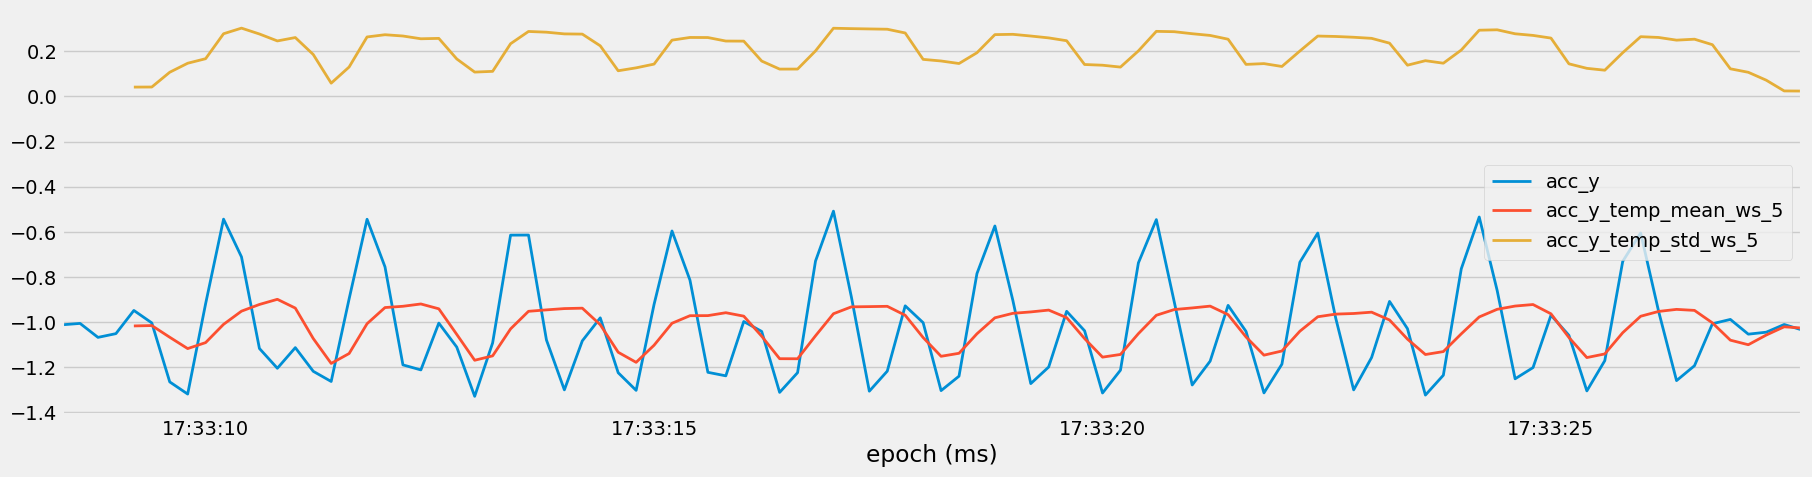

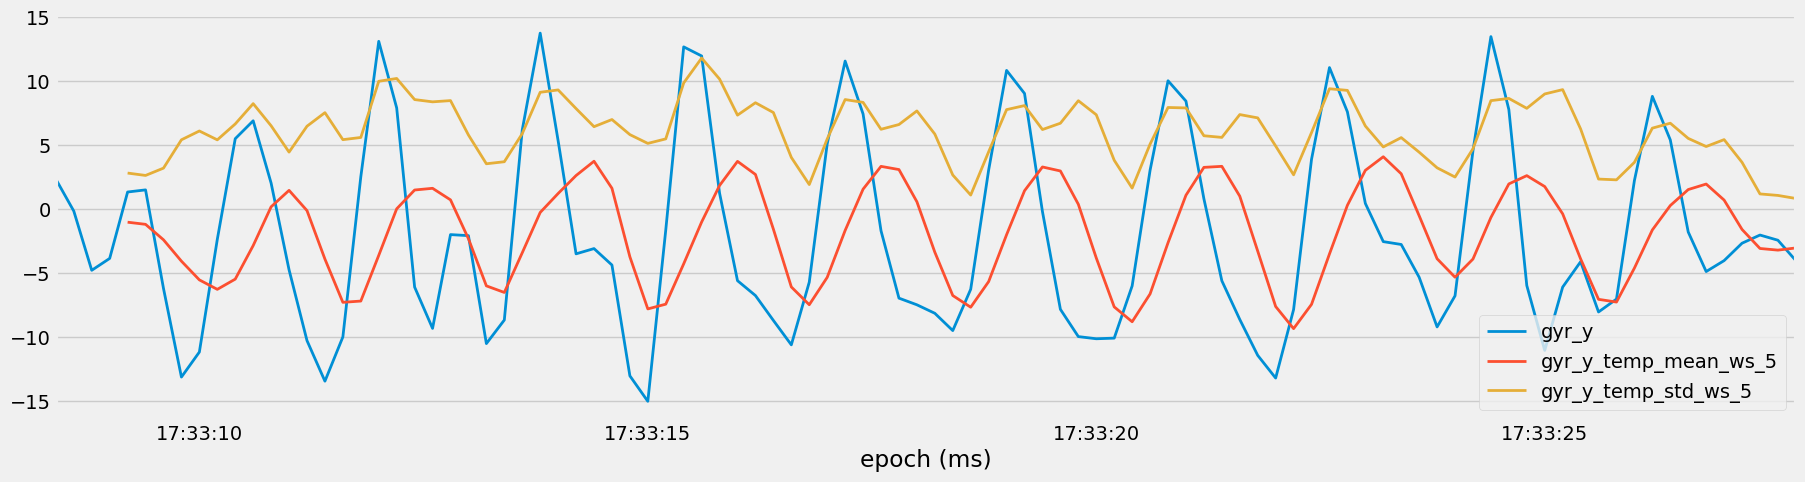

In [63]:
subset[["acc_y", "acc_y_temp_mean_ws_5", "acc_y_temp_std_ws_5"]].plot()
subset[["gyr_y", "gyr_y_temp_mean_ws_5", "gyr_y_temp_std_ws_5"]].plot()

### 3.8 - Frequency Feature Engineering

Since the dataset has features that provide information about the frequency of exercise reps, it may be useful to apply a technique that represents the data as frequency components for a more efficient analysis of the data.

This technique is the Discrete Fourier Transformation, which is used to reduce noise, allowing for more accurate modeling. 

In simple terms, it's like taking a noisily squiggly line and then breaking it down into separate wavy lines, each of which can be defined using sine/cosine functions, for a clearer signal and easier interpretation for the models.

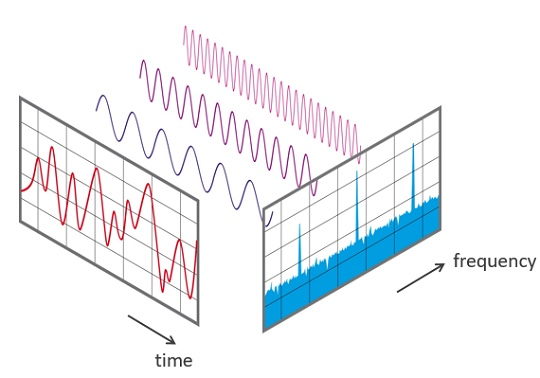

*Image from https://www.nti-audio.com*

The following features will be extracted from each predictive feature (accelerometer and gyroscope):
- Amplitude
- Max frequency
- Weighted mean frequency
- Power spectral entropy

More information about this technique can be found here:

*Source: Hoogendoorn, M., & Funk, B. (2018). Machine learning for the quantified self. On the art of learning from sensory data.*

Or on wikipedia: https://en.wikipedia.org/wiki/Discrete_Fourier_transform

In [64]:
# Import the necessary libraries
from src.features.FrequencyAbstraction import FourierTransformation

# Make a copy of the dataframe from the previous cell with temporal abstraction applied 
# Resetting the index before applying DFT because it expects a time series with a discrete
# index from 0 to n
df_freq = df_temporal.copy().reset_index()

# Create an instance of the FourierTransformation class
FreqAbs = FourierTransformation()

Now we need to define the frequency sampling rate AND the window size. 

Unlike the window size previously used in temporal abstraction, we want to set a larger window size to capture the average time length of a single exercise rep. Given that reps tend to be 2.5-3 seconds each (depending on whether it's a medium or heavy set), we can set the window size to 2.8 seconds divided by the sampling interval (200ms). 

The sampling rate is simply the number of samples per second, which in our case is 5 samples / second (5 Hz).

In [65]:
window_size = int(2800 / 200)
sampling_rate = int(1000 / 200)

Test the DFT technique on one predictor column and plot the results:

<Axes: >

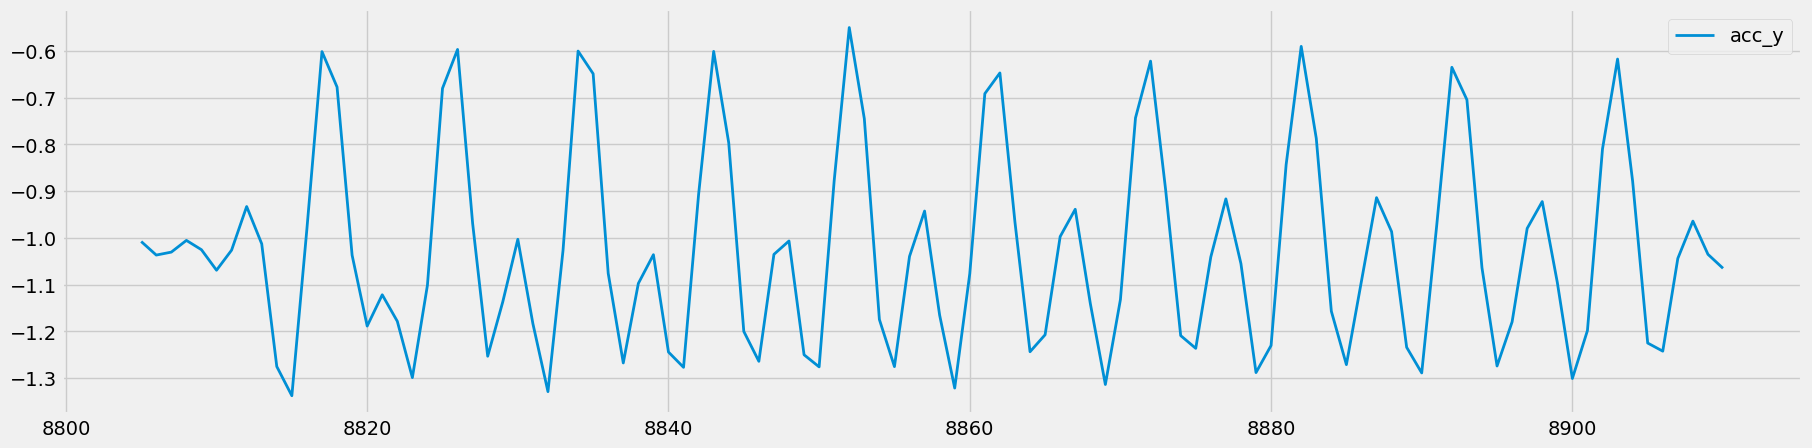

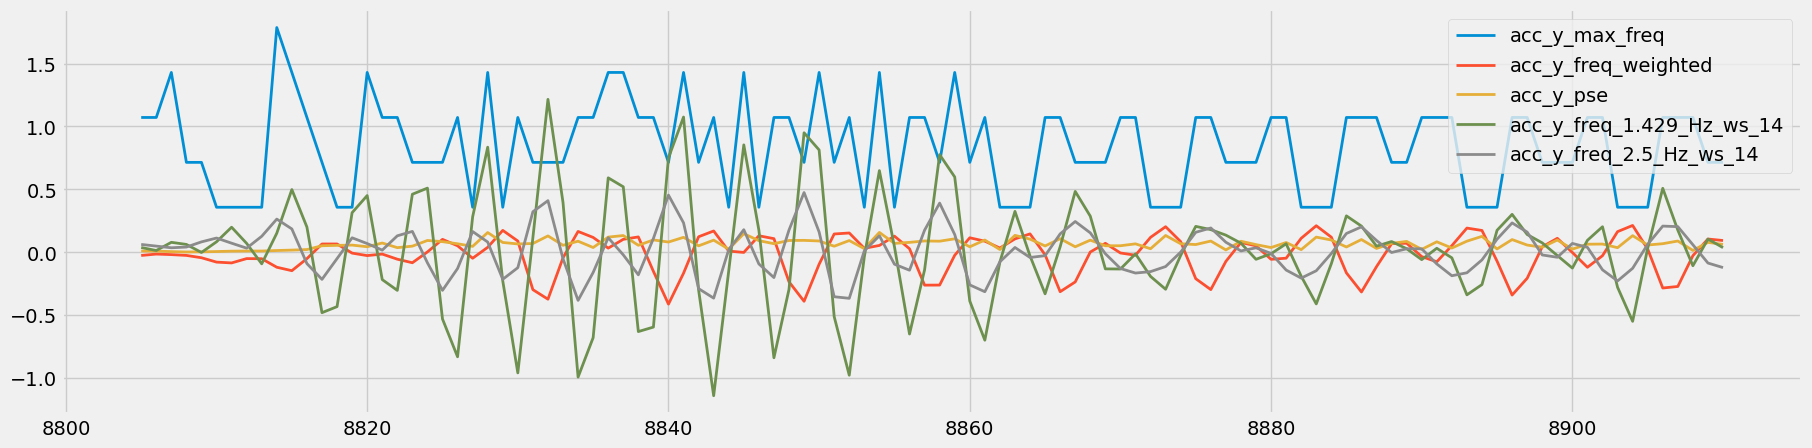

In [66]:
temp_df = FreqAbs.abstract_frequency(df_freq, ["acc_y"], window_size, sampling_rate)

# Visualize the results
subset = temp_df[temp_df["set"] == 15]
subset[["acc_y"]].plot()
subset[
    [
        "acc_y_max_freq",
        "acc_y_freq_weighted",
        "acc_y_pse",
        "acc_y_freq_1.429_Hz_ws_14",
        "acc_y_freq_2.5_Hz_ws_14",
    ]
].plot()

Apply the DFT method on all the predictor columns (including the scalars), looping through each unique set. This will take a couple of minutes:

In [67]:
df_freq_list = []
for s in df_freq["set"].unique():
    print(f"Applying Fourier transofrmations to set {s}")
    subset = df_freq[df_freq["set"] == s].reset_index(drop=True).copy()
    subset = FreqAbs.abstract_frequency(
        subset, pred_col_list, window_size, sampling_rate
    )
    df_freq_list.append(subset)

# Add the new DFT columns to the dataframe
df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

Applying Fourier transofrmations to set 64
Applying Fourier transofrmations to set 72
Applying Fourier transofrmations to set 40
Applying Fourier transofrmations to set 86
Applying Fourier transofrmations to set 80
Applying Fourier transofrmations to set 10
Applying Fourier transofrmations to set 74
Applying Fourier transofrmations to set 52
Applying Fourier transofrmations to set 12
Applying Fourier transofrmations to set 33
Applying Fourier transofrmations to set 77
Applying Fourier transofrmations to set 53
Applying Fourier transofrmations to set 32
Applying Fourier transofrmations to set 79
Applying Fourier transofrmations to set 22
Applying Fourier transofrmations to set 17
Applying Fourier transofrmations to set 69
Applying Fourier transofrmations to set 63
Applying Fourier transofrmations to set 60
Applying Fourier transofrmations to set 92
Applying Fourier transofrmations to set 57
Applying Fourier transofrmations to set 7
Applying Fourier transofrmations to set 16
Applying Fou

There are now 120 total columns in the dataframe:

In [68]:
df_freq.info()
df_freq.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Columns: 120 entries, acc_x to gyr_r_freq_2.5_Hz_ws_14
dtypes: float64(116), int64(1), object(3)
memory usage: 8.3+ MB


,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2019-01-11 15:08:05.200,0.013503,0.977003,-0.071001,-1.886218,2.438803,0.937522,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.400,0.008515,0.973169,-0.066481,-0.367396,0.439794,0.178360,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.600,-0.008450,0.966879,-0.071895,4.320608,-2.083978,-1.217263,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:05.800,-0.024359,0.962244,-0.084774,4.737252,-3.456339,-0.678205,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-11 15:08:06.000,-0.022092,0.959572,-0.096776,0.808615,-1.194575,-1.783172,B,bench,heavy,64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


However, there are some missing values especially at the beginning of the dataframe. Drop these missing values now:

In [69]:
df_freq = df_freq.dropna()
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7735 entries, 2019-01-11 15:08:08 to 2019-01-20 17:33:27.800000
Columns: 120 entries, acc_x to gyr_r_freq_2.5_Hz_ws_14
dtypes: float64(116), int64(1), object(3)
memory usage: 7.1+ MB


Instead of 9009 data points, we now have 7735 data points. With this many data points, we can split off a training set using 50% of the 7735 data points. This does two things - 1) prevents overfitting and 2) allows us to test and validate the model to ensure it generalizes well to new data.

In [70]:
df_freq = df_freq.iloc[::2]
df_freq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3868 entries, 2019-01-11 15:08:08 to 2019-01-20 17:33:27.800000
Columns: 120 entries, acc_x to gyr_r_freq_2.5_Hz_ws_14
dtypes: float64(116), int64(1), object(3)
memory usage: 3.6+ MB


We now have 3868 data points, which is plenty enough for the model to work with.

### 3.9 - KMeans Clustering

The last step to feature engineering is KMeans clustering, an unsupervised machine learning technique that groups data into clusters based on similarity. 

KMeans randomly initializes a given number of centroids in the data space, and then calculates the distance of each data point and all centroids. Then it assigns the data point to the nearest centroid.

Again, using the elbow curve technique, the optimal number of clusters for this given dataset will be determined before running the KMeans model.

In [71]:
# Import the necessary libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Make a copy of the dataframe from the previous cell with DTF applied
df_cluster = df_freq.copy()

Now for a given set of columns to be clustered (just the accelerometer data), we want to find the optimal number of clusters in a range between 2 and 10:

In [72]:
cluster_columns = ["acc_x", "acc_y", "acc_z"]
k_values = range(2, 10)
inertias = []

for k in k_values:
    subset = df_cluster[cluster_columns]
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    cluster_labels = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)

Plot the above results:

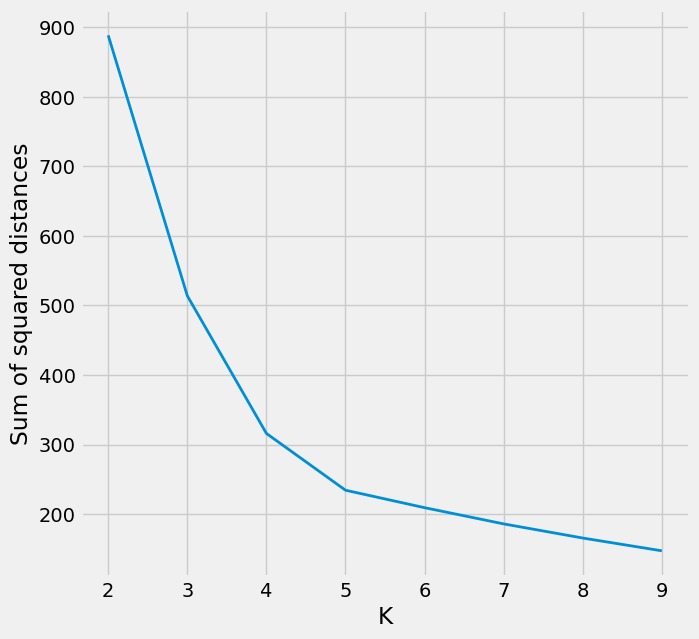

In [73]:
vis.elbow_plot(k_values, inertias)

It appears that the optimal `n_clusters` is 5, so we will use that value for the KMeans model and add a new `Cluster` column to the dataset.

In [74]:
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
subset = df_cluster[cluster_columns]
df_cluster["cluster"] = kmeans.fit_predict(subset)

Check the silhoutte score of the above model:

In [75]:
score = silhouette_score(subset, df_cluster["cluster"])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.5829839551638676


Visualize the clusters in 3D:

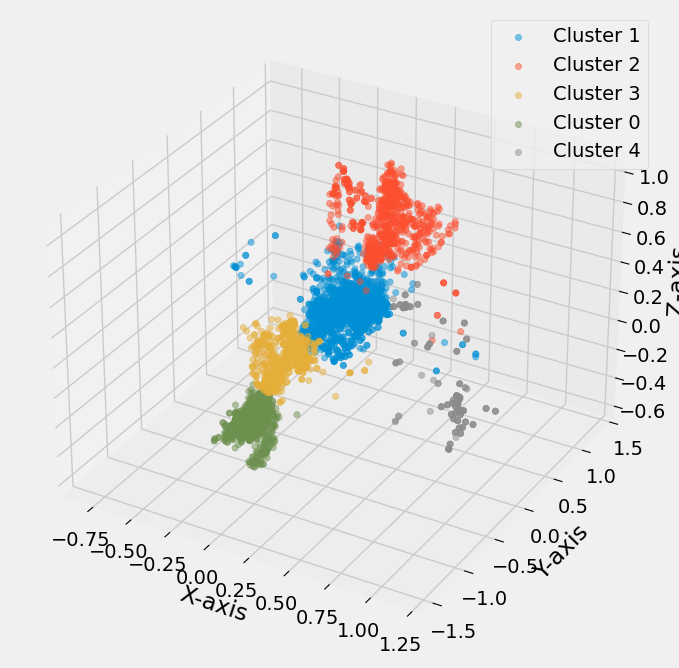

In [76]:
cluster_col = "cluster"
vis.cluster_plot_3d(df_cluster, cluster_col)

Redo the above visualization by labeling each cluster by type of exercise (replace `cluster` with `label`):

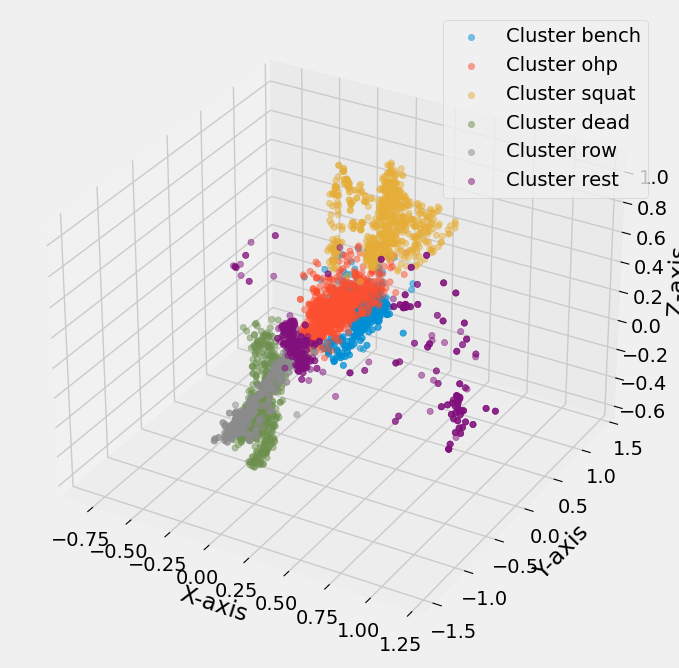

In [77]:
label_col = "label"
vis.cluster_plot_3d(df_cluster, label_col)

Save the fully processed dataset to a new pickle file:

In [78]:
df_cluster.to_pickle("data/interim/03_data_preprocessed.pkl")

## To be continued...

**To begin predictive modeling, continue with Part 4 of this notebook here:**

`/notebooks/nk-fitness-tracker-p4-predictive-modeling.ipynb`

Github link: https://github.com/nkeblawi/nk-fitness-tracker/blob/main/notebooks/nk-fitness-tracker-p4-predictive-modeling.ipynb